<a href="https://colab.research.google.com/github/Samreenhabib/Urdu-OCR/blob/main/making_processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers
!pip install -q datasets

In [69]:
# from transformers import TrOCRProcessor

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# processor.save_pretrained('./ms-processor')

In [110]:
from transformers import AutoFeatureExtractor, AutoTokenizer
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-384")
decoder_tokenizer = AutoTokenizer.from_pretrained("urduhack/roberta-urdu-small")
processor =TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=decoder_tokenizer)

loading configuration file preprocessor_config.json from cache at C:\Users\danis/.cache\huggingface\hub\models--google--vit-base-patch16-384\snapshots\be89a4abf1f427fe502d37f261b8b6d6da7894bc\preprocessor_config.json
loading configuration file config.json from cache at C:\Users\danis/.cache\huggingface\hub\models--google--vit-base-patch16-384\snapshots\be89a4abf1f427fe502d37f261b8b6d6da7894bc\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-384",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo

C:\Users\danis\anaconda3\envs\easyocr-env\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 384. Converted to {'height': 384, 'width': 384}.
Image processor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

loading configuration file config.json from cache at C:\Users\danis/.cache\huggingface\hub\models--urduhack--roberta-urdu-small\snapshots\88b0711632a90aa462d37b3fd01b3

In [111]:
processor.save_pretrained('../test/test_processor')

Image processor saved in ../test/test_processor\preprocessor_config.json
tokenizer config file saved in ../test/test_processor\tokenizer_config.json
Special tokens file saved in ../test/test_processor\special_tokens_map.json


In [112]:
#!pip install -q datasets jiwer

In [113]:
import pandas as pd
import cv2
df = pd.read_excel("sen_dataset.xlsx", header=None)
df.rename(columns={0: "filename", 1: "text"}, inplace=True)
df['text']
df['filename']

0       filename
1          0.png
2          1.png
3          2.png
4          3.png
          ...   
6497    6496.png
6498    6497.png
6499    6498.png
6500    6499.png
6501    6500.png
Name: filename, Length: 6502, dtype: object

In [114]:
df.head()

,filename,text
0,filename,text
1,0.png,فہرست اداریہ ڈاکٹر ثروت رضوی ۴ اقبال کی شاعران...
2,1.png,جمیل یوسف ۵ ———— پروین شاکر کی یاد میں شاہدہ
3,2.png,حسن ۱۲ شاعری میں تانیثیت کے منظرنامے پر دستخط صدف
4,3.png,مرزا ۱۹ پروین شاکر رضیہ سبحان ۳۷ عکسِ خوشبو ہوں—


In [137]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3)
# we reset the indices to start from zero
train_df.dropna()
test_df.dropna()
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [138]:
test_df.head()

,filename,text
0,5850.png,کر غم دل خدا سے دعا کر(گلوکار:لتا منگیشکر) ۷۔ جا
1,4424.png,ہے اور جاوید سے خطاب یا (نژادِ نو سے خطاب)
2,2716.png,ماہرِ تعلیم یہ بتانا پسند کرے گا کہ جن طلبہ
3,1545.png,اور ممتا سے بھری ماں نظر آتی ہیں۔ اب ان
4,5646.png,نہ ملا‘‘۔تاج کا ڈراما انارکلی، پلاٹ، کردار، مک...


In [139]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['filename'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length",max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [140]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("../test/test_processor")

train_dataset = IAMDataset(root_dir='../NMT - FYP/images/',
                           df=train_df,
                           processor=processor)

eval_dataset = IAMDataset(root_dir='../NMT - FYP/images/',
                           df=test_df,
                           processor=processor)

loading configuration file ../test/test_processor\preprocessor_config.json
C:\Users\danis\anaconda3\envs\easyocr-env\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Image processor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "TrOCRProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [141]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 4551
Number of validation examples: 1951


In [142]:
train_dataset

In [143]:
train_dataset[6]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': tensor([    0, 17082,   316,  1842,  3500,   340,   333

In [144]:
encoding = train_dataset[3]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


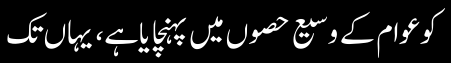

In [145]:
image = Image.open(train_dataset.root_dir + train_df['filename'][3]).convert("RGB")
image

In [146]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

کو عوام کے وسیع حصوں میں پہنچایا ہے، یہاں تک


In [147]:
from transformers import VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-384", "urduhack/roberta-urdu-small")

# set decoder config to causal lm
model.config.decoder.is_decoder = True
model.config.decoder.add_cross_attention = True

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

loading configuration file config.json from cache at C:\Users\danis/.cache\huggingface\hub\models--google--vit-base-patch16-384\snapshots\be89a4abf1f427fe502d37f261b8b6d6da7894bc\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-384",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linne

loading weights file pytorch_model.bin from cache at C:\Users\danis/.cache\huggingface\hub\models--google--vit-base-patch16-384\snapshots\be89a4abf1f427fe502d37f261b8b6d6da7894bc\pytorch_model.bin
Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probabl

Generation config file not found, using a generation config created from the model config.
Setting `config.is_decoder=True` and `config.add_cross_attention=True` for decoder_config
Generate config GenerationConfig {
  "transformers_version": "4.26.1"
}



using steps 

In [148]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    fp16=False, 
    output_dir="./",
    logging_steps=50,
    save_steps=20,
    eval_steps=20,
    num_train_epochs=40,  
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


evaluating using epoch

In [149]:
training_args = Seq2SeqTrainingArguments(
   evaluation_strategy = "epoch",
   learning_rate=2e-2,
   per_device_train_batch_size=2,
   per_device_eval_batch_size=2,
   weight_decay=0.01,
   save_total_limit=2,
   num_train_epochs=40,
   output_dir="./train/",
   predict_with_generate=True,  
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [150]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [151]:
pip install jiwer

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [152]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [153]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [154]:
import os
from openpyxl import load_workbook

def compare_images_with_excel(file_path, folder_path, column_name):
    # Load the Excel file
    workbook = load_workbook(file_path)
    sheet = workbook.active
    
    # Get the column index based on the column name
    column_index = None
    for cell in sheet[1]:
        if cell.value == column_name:
            column_index = cell.column_letter
            break
    
    # Check if the column was found
    if column_index is None:
        print(f"Column '{column_name}' not found in the Excel file.")
        return
    
    # Iterate over the values in the specified column
    for cell in sheet[column_index][1:]:
        image_filename = cell.value
        
        # Construct the full image path
        image_path = os.path.join(folder_path, image_filename)
        
        # Check if the image file exists
        if os.path.isfile(image_path):
            print(f"Image '{image_filename}' found in the folder.")
            folder.append(image_filename)
        else:
            print(f"Image '{image_filename}' not found in the folder.")
    
    # Close the workbook
    workbook.close()

# Example usage
excel_file_path = "sen_dataset.xlsx"
image_folder_path = "C:/Working_Directory/NCL/Urdu_OCR/FYP/NMT - FYP/images"
column_name = "filename"
folder = []

compare_images_with_excel(excel_file_path, image_folder_path, column_name)
len(folder)

Image '0.png' found in the folder.
Image '1.png' found in the folder.
Image '2.png' found in the folder.
Image '3.png' found in the folder.
Image '4.png' found in the folder.
Image '5.png' found in the folder.
Image '6.png' found in the folder.
Image '7.png' found in the folder.
Image '8.png' found in the folder.
Image '9.png' found in the folder.
Image '10.png' found in the folder.
Image '11.png' found in the folder.
Image '12.png' found in the folder.
Image '13.png' found in the folder.
Image '14.png' found in the folder.
Image '15.png' found in the folder.
Image '16.png' found in the folder.
Image '17.png' found in the folder.
Image '18.png' found in the folder.
Image '19.png' found in the folder.
Image '20.png' found in the folder.
Image '21.png' found in the folder.
Image '22.png' found in the folder.
Image '23.png' found in the folder.
Image '24.png' found in the folder.
Image '25.png' found in the folder.
Image '26.png' found in the folder.
Image '27.png' found in the folder.
Im

Image '4582.png' found in the folder.
Image '4583.png' found in the folder.
Image '4584.png' found in the folder.
Image '4585.png' found in the folder.
Image '4586.png' found in the folder.
Image '4587.png' found in the folder.
Image '4588.png' found in the folder.
Image '4589.png' found in the folder.
Image '4590.png' found in the folder.
Image '4591.png' found in the folder.
Image '4592.png' found in the folder.
Image '4593.png' found in the folder.
Image '4594.png' found in the folder.
Image '4595.png' found in the folder.
Image '4596.png' found in the folder.
Image '4597.png' found in the folder.
Image '4598.png' found in the folder.
Image '4599.png' found in the folder.
Image '4600.png' found in the folder.
Image '4601.png' found in the folder.
Image '4602.png' found in the folder.
Image '4603.png' found in the folder.
Image '4604.png' found in the folder.
Image '4605.png' found in the folder.
Image '4606.png' found in the folder.
Image '4607.png' found in the folder.
Image '4608.

6501

In [1]:
import os

def print_files_in_folder(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Iterate over the files and print their names
    for file_name in files:
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        
        # Check if the file is a regular file
        if os.path.isfile(file_path):
            print(file_name)
            folder.append(file_name)

# Example usage
folder_path = "C:/Working_Directory/NCL/Urdu_OCR/FYP/NMT - FYP/images"
folder = []
print_files_in_folder(folder_path)
len(folder)

0.png
1.png
10.png
100.png
1000.png
1001.png
1002.png
1003.png
1004.png
1005.png
1006.png
1007.png
1008.png
1009.png
101.png
1010.png
1011.png
1012.png
1013.png
1014.png
1015.png
1016.png
1017.png
1018.png
1019.png
102.png
1020.png
1021.png
1022.png
1023.png
1024.png
1025.png
1026.png
1027.png
1028.png
1029.png
103.png
1030.png
1031.png
1032.png
1033.png
1034.png
1035.png
1036.png
1037.png
1038.png
1039.png
104.png
1040.png
1041.png
1042.png
1043.png
1044.png
1045.png
1046.png
1047.png
1048.png
1049.png
105.png
1050.png
1051.png
1052.png
1053.png
1054.png
1055.png
1056.png
1057.png
1058.png
1059.png
106.png
1060.png
1061.png
1062.png
1063.png
1064.png
1065.png
1066.png
1067.png
1068.png
1069.png
107.png
1070.png
1071.png
1072.png
1073.png
1074.png
1075.png
1076.png
1077.png
1078.png
1079.png
108.png
1080.png
1081.png
1082.png
1083.png
1084.png
1085.png
1086.png
1087.png
1088.png
1089.png
109.png
1090.png
1091.png
1092.png
1093.png
1094.png
1095.png
1096.png
1097.png
1098.png
1099.png
1

3683.png
3684.png
3685.png
3686.png
3687.png
3688.png
3689.png
369.png
3690.png
3691.png
3692.png
3693.png
3694.png
3695.png
3696.png
3697.png
3698.png
3699.png
37.png
370.png
3700.png
3701.png
3702.png
3703.png
3704.png
3705.png
3706.png
3707.png
3708.png
3709.png
371.png
3710.png
3711.png
3712.png
3713.png
3714.png
3715.png
3716.png
3717.png
3718.png
3719.png
372.png
3720.png
3721.png
3722.png
3723.png
3724.png
3725.png
3726.png
3727.png
3728.png
3729.png
373.png
3730.png
3731.png
3732.png
3733.png
3734.png
3735.png
3736.png
3737.png
3738.png
3739.png
374.png
3740.png
3741.png
3742.png
3743.png
3744.png
3745.png
3746.png
3747.png
3748.png
3749.png
375.png
3750.png
3751.png
3752.png
3753.png
3754.png
3755.png
3756.png
3757.png
3758.png
3759.png
376.png
3760.png
3761.png
3762.png
3763.png
3764.png
3765.png
3766.png
3767.png
3768.png
3769.png
377.png
3770.png
3771.png
3772.png
3773.png
3774.png
3775.png
3776.png
3777.png
3778.png
3779.png
378.png
3780.png
3781.png
3782.png
3783.png
3784

715.png
716.png
717.png
718.png
719.png
72.png
720.png
721.png
722.png
723.png
724.png
725.png
726.png
727.png
728.png
729.png
73.png
730.png
731.png
732.png
733.png
734.png
735.png
736.png
737.png
738.png
739.png
74.png
740.png
741.png
742.png
743.png
744.png
745.png
746.png
747.png
748.png
749.png
75.png
750.png
751.png
752.png
753.png
754.png
755.png
756.png
757.png
758.png
759.png
76.png
760.png
761.png
762.png
763.png
764.png
765.png
766.png
767.png
768.png
769.png
77.png
770.png
771.png
772.png
773.png
774.png
775.png
776.png
777.png
778.png
779.png
78.png
780.png
781.png
782.png
783.png
784.png
785.png
786.png
787.png
788.png
789.png
79.png
790.png
791.png
792.png
793.png
794.png
795.png
796.png
797.png
798.png
799.png
8.png
80.png
800.png
801.png
802.png
803.png
804.png
805.png
806.png
807.png
808.png
809.png
81.png
810.png
811.png
812.png
813.png
814.png
815.png
816.png
817.png
818.png
819.png
82.png
820.png
821.png
822.png
823.png
824.png
825.png
826.png
827.png
828.png
829.p

6501

In [156]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)
trainer.train()

C:\Users\danis\anaconda3\envs\easyocr-env\lib\site-packages\transformers\models\trocr\processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
C:\Users\danis\anaconda3\envs\easyocr-env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4551
  Num Epochs = 40
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 91040
  Number of trainable parameters = 241079584


Epoch,Training Loss,Validation Loss


Saving model checkpoint to ./train/checkpoint-500
Configuration saved in ./train/checkpoint-500\config.json
Configuration saved in ./train/checkpoint-500\generation_config.json
Model weights saved in ./train/checkpoint-500\pytorch_model.bin
Image processor saved in ./train/checkpoint-500\preprocessor_config.json
Deleting older checkpoint [train\checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to ./train/checkpoint-1000
Configuration saved in ./train/checkpoint-1000\config.json
Configuration saved in ./train/checkpoint-1000\generation_config.json
Model weights saved in ./train/checkpoint-1000\pytorch_model.bin
Image processor saved in ./train/checkpoint-1000\preprocessor_config.json
Deleting older checkpoint [train\checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to ./train/checkpoint-1500
Configuration saved in ./train/checkpoint-1500\config.json
Configuration saved in ./train/checkpoint-1500\generation_config.json
Model weights saved in ./trai

FileNotFoundError: [Errno 2] No such file or directory: '../NMT - FYP/images/filename'

In [ ]:
trainer.save_model('./trainer')

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("./trainer")

In [ ]:
image = Image.open('/content/6.png').convert("RGB")

In [ ]:
image

In [ ]:
pixel_values = processor.feature_extractor(image, return_tensors="pt").pixel_values 
print(pixel_values.shape)

In [ ]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

In [ ]:
test = Image.open('/content/8.png').convert("RGB")
testvalues = processor.feature_extractor(test, return_tensors="pt").pixel_values 
print(testvalues.shape)

In [ ]:
testids = model.generate(testvalues)
testtext = processor.batch_decode(testids, skip_special_tokens=True)[0]
print(testtext)